In [8]:
import os  # Import os for path management
from data_utils_timm import get_loader
import torch
import pandas as pd
import numpy as np

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, save_dir, test_csv_file):
    model.to(device)  # Move model to the appropriate device (CPU or GPU)
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Get the total number of batches
        total_batches = len(train_loader)

        for step, (images, labels) in enumerate(train_loader):
            labels = labels.view(20, -1)  # TODO: Adjust batch size dynamically if needed
            images, labels = images.to(device), labels.to(device)  # Move to device
            
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * images.size(0)  # Accumulate loss

            # Print step progress
            if step % 10 == 0 or step == total_batches - 1:  # Print every 10 steps and the last step
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{total_batches}], Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")

        # Validation step
        if test_loader is not None:
            model.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            all_outputs = []  # List to hold outputs
            image_names = []  # List to hold image names
            
            with torch.no_grad():
                for step, (images, labels) in enumerate(test_loader):
                    labels = labels.view(images.size(0), -1)  # Dynamically reshape based on batch size
                    images, labels = images.to(device), labels.to(device)
                    
                    # Get the predictions from the model
                    outputs = model(images)  
                    all_outputs.append(outputs.cpu().detach().numpy())  # Collect predictions

                    # Assuming test_csv_file contains the image names corresponding to the test set
                    if step == 0:  # Assuming the same image names for every step; typically you would read it outside the loop
                        image_names.extend(pd.read_csv(test_csv_file)["image_name"].tolist())

                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)  # Accumulate loss
            
            val_loss /= len(test_loader.dataset)
            print(f"Validation Loss: {val_loss:.4f}")

            # Save outputs to CSV after processing all batches
            all_outputs = np.vstack(all_outputs)  # Stack all outputs into a single array
            d_preds = pd.DataFrame(all_outputs)  # Convert outputs to DataFrame
            d_preds["image_names"] = image_names  # Add image names to DataFrame

            # Save DataFrame to CSV
            predictions_csv_path = os.path.join(save_dir, "predictions.csv")
            d_preds.to_csv(predictions_csv_path, index=False)
            print(f"Validation outputs saved to {predictions_csv_path}")

        # Save the model after every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Ensure the directory exists before saving
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            save_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at: {save_path}")

    print("Training complete.")



In [9]:
import os
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import torch
# Set your paths and parameters directly
current_dir = os.getcwd()
train_csv_file = os.path.join(current_dir,"projects/Facemap/data/train/augmented_data/augmented_labels.csv")
train_data_dir = os.path.join(current_dir, "projects/Facemap/data/train/augmented_data")
test_csv_file = os.path.join(current_dir,"projects/Facemap/data/test/augmented_data/augmented_labels.csv")
test_data_dir = os.path.join(current_dir, "projects/Facemap/data/test/augmented_data")
save_dir = os.path.join(current_dir, "projects/Facemap/data/output")
train_batch_size = 20
eval_batch_size = 20
num_epochs = 50  # Set your desired number of epochs

# Initialize the DataLoader
train_loader, test_loader = get_loader(train_csv_file, train_data_dir, test_csv_file, test_data_dir, train_batch_size, eval_batch_size)

# Create the model
model = create_model('vit_base_patch16_224', pretrained=True)

# Modify the last layer for regression
num_keypoints = 12
num_coordinates = num_keypoints * 2
model.head = nn.Linear(model.head.in_features, num_coordinates)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()


In [11]:

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, save_dir=save_dir, test_csv_file=test_csv_file)

Epoch [1/50], Step [1/45], Loss: 10091.2617
Epoch [1/50], Step [11/45], Loss: 8851.2686
Epoch [1/50], Step [21/45], Loss: 7964.9214
Epoch [1/50], Step [31/45], Loss: 8221.0996
Epoch [1/50], Step [41/45], Loss: 7406.0513
Epoch [1/50], Step [45/45], Loss: 7814.9648
Epoch [1/50], Average Loss: 8476.6151
Validation Loss: 7648.6466
Validation outputs saved to c:\Users\avs20\Documents\GitHub\ViT_facemap\ViT-timm\projects/Facemap/data/output\predictions.csv
Epoch [2/50], Step [1/45], Loss: 8726.3584
Epoch [2/50], Step [11/45], Loss: 7422.9683
Epoch [2/50], Step [21/45], Loss: 6808.5449
Epoch [2/50], Step [31/45], Loss: 6708.4814
Epoch [2/50], Step [41/45], Loss: 6796.7607
Epoch [2/50], Step [45/45], Loss: 6148.7134
Epoch [2/50], Average Loss: 6939.7081
Validation Loss: 6226.7947
Validation outputs saved to c:\Users\avs20\Documents\GitHub\ViT_facemap\ViT-timm\projects/Facemap/data/output\predictions.csv
Epoch [3/50], Step [1/45], Loss: 5980.3608
Epoch [3/50], Step [11/45], Loss: 5688.5503
Epoc

# Plot predictions

In [2]:
from timm import create_model
import torch.nn as nn
# Create the model
model = create_model('vit_base_patch16_224', pretrained=True)

# Modify the last layer for regression
num_keypoints = 12
num_coordinates = num_keypoints * 2
model.head = nn.Linear(model.head.in_features, num_coordinates)
# Load the trained model
model.load_state_dict(torch.load('model_epoch_50.pth'))

print(model)

# Check if GPU is available and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the appropriate device
model.eval()  # Set to evaluation mode

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [3]:
from torchvision import transforms

# Define the transform (assuming this is required elsewhere)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Uncomment if resizing is needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
from pathlib import Path
from PIL import Image

# Define the data path in an OS-independent way
data_path = Path("projects") / "Facemap" / "data" / "test" / "augmented_data"

# Define the image name

#imageName = 'cam1_G7c1_1_img0703_pad_rescale_augmented.jpg'
#imageName = 'cam1_G7c1_1_img0703_rotate_rescale_augmented.jpg'
imageName = 'cam1_G7c1_1_img0703_flip_rescale_augmented.jpg'


# Open the image (using the / operator to concatenate the path and file name)
im = Image.open(data_path / imageName)

x = transform(im)

#print(x)[0]

In [19]:

import pandas as pd

labels = pd.read_csv(data_path /'augmented_labels.csv')
labelsKepoints = labels.loc[labels['image_name'] == imageName].values.flatten().tolist()[1:]

pred_path = Path("projects") / "Facemap" / "data" / "output"
preds = pd.read_csv(pred_path /'predictions.csv')
predsKeypoints = preds.loc[labels['image_name'] == imageName].values.flatten().tolist()[0:-1]

print(predsKeypoints)


[72.410675, 44.774597, 92.73835, 56.180325, 77.49558, 73.61656, 60.310333, 68.95007, 178.43109, 63.931435, 189.44856, 77.737434, 183.09207, 91.09406, 139.28111, 89.13622, 135.09842, 78.330864, 137.76588, 101.47493, 143.62498, 129.65302, 133.74973, 137.57762]


In [22]:
import torch

# Assuming 'transform' and 'model' are defined somewhere in your code
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and transform the image
x = transform(im).to(device)  # Move the transformed image to the appropriate device

# Move the model to the same device
model.to(device)

# Set model to evaluation mode
model.eval()

# Get model output
with torch.no_grad():  # Disable gradient calculation for inference
    out = model(x.unsqueeze(0))  # Ensure input is batched

print(out.shape)
# Convert the model output to a format suitable for plotting
keypoints = out[0].detach().cpu().numpy()  # Detach and move to CPU if using a GPU

# Access the first row of keypoints since shape is (1, 24)
#keypoints = keypoints[0]

#print(keypoints)



torch.Size([1, 24])


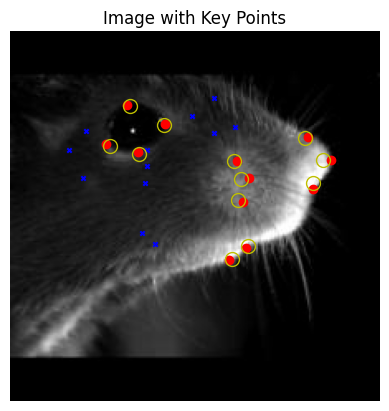

In [21]:
import matplotlib.pyplot as plt


plt.imshow(im)
# Loop through the keypoints and plot them
for i in range(0, len(keypoints), 2):
    x_coord = keypoints[i]
    y_coord = keypoints[i + 1]
    plt.scatter(x_coord, y_coord, s=10, c='blue', marker='x')  # Plot each keypoint
for i in range(0, 23, 2):
    plt.plot(labelsKepoints[i], labelsKepoints[i+1], 'ro')
    plt.plot(predsKeypoints[i], predsKeypoints[i+1], 'yo', markerfacecolor='none', markersize=10) #allows us to plot x+y coordinate of each key point (i+1) and loops over the 24 keypoints, skipping every second step since we plot both x+y 

plt.title("Image with Key Points")
plt.axis('off')  # Turn off axis labels
plt.show()
 